![title](logo.png)

# Biometrics System Concepts

# Assignment 1: Fingerprint Recognition

Implement and test a key-point based fingerprint recognition/verification system.

A high-level description is provided with links to or hints of code snippets and libraries that you can reuse/adapt at your will (with proper referencing!).

The following steps need to be implemented:
1. Importing the required packages
2. Reading image data, conversion to gray-scale
3. Preprocessing: Enhancement using orientation/frequency filtering and Segmentation of foreground 
4. "Minutiae" detection using keypoint detectors and descriptors from OpenCV
5. Matching using keypoint matching
6. **Validation using a verification and identification scenario** (cf. previous assignment)

For steps 1-5, code examples will be provided below. You can and are invited to adapt these at your will (different parameter settings, different choices of alogorithmic components). 

## CODE EXAMPLE

### 1. Importing packages


In [1]:
# OpenCV package
import cv2
# standard array processing package
import numpy as np
# Plotting library
from matplotlib import pyplot as plt
#to plot the figures inside the notebook:
%matplotlib inline
# file path processing package
from pathlib import Path
# local modules for fingerprint enhancement
import fprmodules.enhancement as fe
# package for some simple biometric metrics. 
# Of course you can use the code you have developed in the previous assignment
# import pyeer
from sklearn.metrics import roc_curve
# Pickle allows to save and read intermediate results (similar to save and load in Matlab)
import pickle
# a visual progress bar library
from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm

### 2. Reading image data and conversion to gray scale

We will make use of the Fingerprint Verification Competition'2002 Database ([FVC'2002](http://bias.csr.unibo.it/fvc2002/default.asp)) images. This was the second in a series of benchmark tests that were made publically available. While we do not have access to the full (880 images) database, you can test your algorithm on a subset of 80 images (10 individuals/fingers, 8 fingerprints per finger). Eventually, you can compare your results to the results that other competitors have uploaded. 

In [2]:
# read a whole database, stored in a single folder with filenames as XXY.tig with XX the individual number and Y the fingerprint number for this individual
# returns a list of images and a list of associated identity labels

def read_DB(path):
    images = []
    labels = []
    imagePaths = sorted(Path(path).rglob("*.tif"))
#     for imagePath in imagePaths:
    for imagePath in tqdm_notebook(imagePaths):
        image = cv2.imread(path + imagePath.name)
        if (len(image.shape) > 2):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(image)
        label = imagePath.stem[1:3]
        labels.append(label)
    return (images, labels)

# select a Database
images_db1, labels_db1 = read_DB('./fprdata/FVC2002/DB1_B/')
# images_db2, labels_db2 = read_DB('./fprdata/FVC2002/DB2_B/')
# images_db3, labels_db3 = read_DB('./fprdata/FVC2002/DB3_B/')
# images_db4, labels_db4 = read_DB('./fprdata/FVC2002/DB4_B/')

In [ ]:
# # Verify by showing some images
print(images_db1[0].shape)
plt.imshow(images_db1[0],cmap='gray')
plt.show()

### 3. Preprocessing: enhancement using ridge orientation/frequency estimation and segmentation of foreground

We will re-use code developed by [Utkarsh Deshmukh](https://github.com/Utkarsh-Deshmukh/Fingerprint-Enhancement-Python), which is a Python-recode of Matlab-code developed by [Peter Kovesi](https://www.peterkovesi.com/matlabfns/index.html#fingerprints). I have slightly adapted this code to make it more compliant with OpenCV. 

It uses gradient-based orientation and local frequency estimation as input to an orientation and frequency selective filtering using a Gabor filterbank. 

At the same time a foreground region segmentation (mask) is determined by calculating the standard deviation in local windows and thresholding above a certain level. 

In [3]:
# Calcuate the enhanced images and the associated segmentation masks

def enhance_images(images):
    images_e_u = []
    masks = []
#     for i, image in enumerate(tqdm_notebook(images)):
    for i, image in tqdm(enumerate(images)):

        try:
            # Gabor filtering
            img_e, mask, orientim, freqim = fe.image_enhance(image)
            # Normalize in the [0,255] range
            img_e_u = cv2.normalize(img_e, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=0)
            images_e_u.append(img_e_u)
        except:
            print('error for: ', i)
            images_e_u.append(image)
        masks.append(mask)
    return images_e_u, masks

In [ ]:
images_enhanced_db1, masks_db1 = enhance_images(images_db1)
# # images_db2 = enhance_images(images_db2)
# # images_db3 = enhance_images(images_db3)
# # images_db4 = enhance_images(images_db4)

In [ ]:
# intermediate (computation heavy) results can be saved on file using the pickle package
p_file = open( "./fprdata/DB1_enhanced.p", "wb" )
pickle.dump([images_enhanced_db1, labels_db1, masks_db1], p_file)


In [4]:
# and read back for further processing
p_file = open( "./fprdata/DB1_enhanced.p", "rb" )
[images_enhanced_db1, labels_db1, masks_db1] = pickle.load(p_file)

<Figure size 432x288 with 0 Axes>

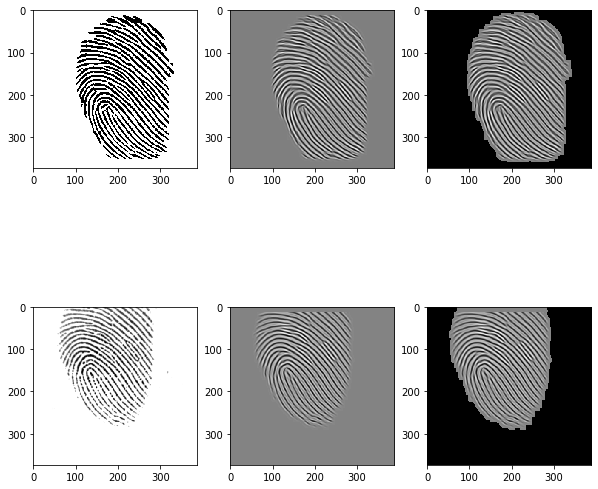

In [5]:
# Verify by showing some input and processed images

ax = plt.figure()
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize=(10,10))
ax[0,0].imshow(images_db1[0], cmap='gray')
ax[0,1].imshow(images_enhanced_db1[0], cmap='gray')
ax[0,2].imshow(images_enhanced_db1[0]*masks_db1[0], cmap='gray')

ax[1,0].imshow(images_db1[1], cmap='gray')
ax[1,1].imshow(images_enhanced_db1[1], cmap='gray')
ax[1,2].imshow(images_enhanced_db1[1]*masks_db1[1], cmap='gray')
plt.show()

### 4. Keypoint Extraction and matching
The basis/traditional fingerprint matching algorithm is based on matching keypoints, called minutiae. They are defined as the ridge endings and bifurcations and can be determined by first thresholding the FP image and skeletonizing/thinning the enhanced image. For those really interested (but not part of this assignment) in experimenting with such an approach, some code is provided in the fprmodules/minutiae_extraction folder.

Instead, we will rely on establised methods developed in Computer Vision, where the use of keypoint features has proven to be very succesfull (prior to the advent of Deep Learning) in image classification, image alignment and object recognition tasks.

In this assignment, you are encouraged to try out a series of detection/description/matching algorithms. A short overview of these methods can be found in the OpenCV documentation: [keypoint_detection_descrption_matching](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html#py-table-of-content-feature2d).
Please read these pages carefully and try to understand these methods.

#### 4.1 Keypoint detection and feature description

Below, you find one example, that uses ORB features. You can experiment with other feature descriptors and [matching routines](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html#matcher) as presented on these pages.

In this template code, we detect and describe keypoints and features. You can test the whole procedure for different detectors. We expect that the keypoints will be detected at "interesting" locations, where locally things seem to change drastically (endings, bifurcations, cores, deltas ...) 

In [6]:
# call ORB keypoint detector and descriptor
# this can be supplemented with other detectors

def detect_ORB(image, max_features = 500):
    orb = cv2.ORB_create(max_features)
    kp1, desc1 = orb.detectAndCompute(image, None)
    return kp1, desc1

In [7]:
# many false keypoints will be generated at the edge of the foreground mask, since ridges seem to terminate due to the clipping.
# we remove these by a morpholigical erosion (shrinking) of the foreground mask and deleting the keypoints outside.

def remove_edge_kps(mask, kp, desc):
    mask_b = mask.astype(np.uint8)  #convert to an unsigned byte
    # morphological erosion
    mask_b*=255
    mask_e = cv2.erode(mask_b, kernel = np.ones((5,5),np.uint8), iterations = 5)
    # remove keypoints and their descriptors that lie outside this eroded mask
    kpn = [kp[i] for i in range(len(kp)) if mask_e.item(int(kp[i].pt[1]),int(kp[i].pt[0])) == 255]
    descn = np.vstack([desc[i] for i in range(len(kp)) if mask_e.item(int(kp[i].pt[1]),int(kp[i].pt[0])) == 255])
    return kpn, descn

<Figure size 432x288 with 0 Axes>

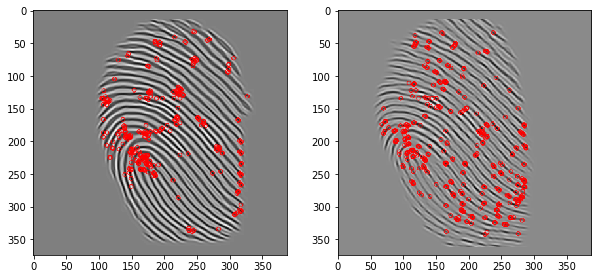

In [8]:
# test example

testNr1 = 0
testNr2 = 7
# find the keypoints and descriptors with ORB for two images of the same finger

kp1, des1 = detect_ORB(images_enhanced_db1[testNr1], max_features = 500)
kp1, des1 = remove_edge_kps(masks_db1[testNr1], kp1, des1)

kp2, des2 = detect_ORB(images_enhanced_db1[testNr2], max_features = 500)
kp2, des2 = remove_edge_kps(masks_db1[testNr2], kp2, des2)

# plot the keypoints and inspect how genuine they are and if there is a subset that seems to match left and right
show_img1 = cv2.drawKeypoints(images_enhanced_db1[testNr1], kp1, None, (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)
show_img2 = cv2.drawKeypoints(images_enhanced_db1[testNr2], kp2, None, (255, 0, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)

ax = plt.figure()
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))
ax[0].imshow(show_img1)
ax[1].imshow(show_img2)
plt.show()

#### 4.2 Local Matching by feature vector comparison

Once all images have been processed we can start matching the keypoints between the images. 

We can do this on a purely **local level** by comparing the feature decriptors in one image with the feature descriptors in the other image. Note that these feature descriptors give a vectorial summary of the neighbourhood around each keypoint. A simple metric on these vectors (Euclidean Distance for continuous variables, Hamming Distance for binary variables) can then be used to determine similarity. 

A simple Brute Force matching strategy is to measure these distances between every possible pair of keypoints (descriptors) in both images. We can then define simple scalar measures on this set of distances, such as the number of pairs with a distance smaller than a set threshold, or the sum/mean of the first N distances (ranked from small to larger), etc. 


In [9]:
# Brute Force matcher on a pair of KeyPoint sets using the local descriptor for similarity

def match_BruteForce_local(image1, image2, des1, des2):
        
    # Brute Force all pair matcher: returns all pairs of best matches
    # depending on type of descriptor use the corresponding norm
    # crossCheck=True only retains pairs of keypoints that are each other best matching pair
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    # sort matches based on feature distance
    matches.sort(key=lambda x: x.distance, reverse=False)
    
    return matches

matches = match_BruteForce_local(images_enhanced_db1[testNr1], images_enhanced_db1[testNr2], des1, des2)

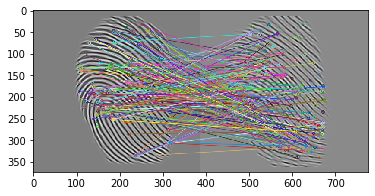

(<matplotlib.image.AxesImage at 0x29dfec5fc88>, None)

In [10]:
# show the result using drawMatches

imMatches = cv2.drawMatches(images_enhanced_db1[testNr1],kp1,
                            images_enhanced_db1[testNr2],kp2,matches, None) 
plt.imshow(imMatches),plt.show()

#### 4.3 Global matching by testing geometrical consistency

[Here](https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/) you can find a decsription and code how to start from the brute force matching results and estimate the best transformation (from a family of transformations) that aligns the two images. In the example given [here](https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/), a homography-type transformation is searched for. However, this has too many degrees of freedom for our application. We substituted this by a more constrained (only 4 degrees of freedom) similarity (partial affine) transformation.
These routines iteratively determine the minimal set of matching points that define a transformation that optimally aligns all other points as well, taking care of outliers at the same time. This method is a very general optimization technique and is called RANSAC, for "RANdom SAmple Consensus". See, apart from many other sources on the internet, [this presentation](http://www.cse.psu.edu/~rtc12/CSE486/lecture15.pdf) for further explanation. 

In [11]:
def match_BruteForce_global(image1, image2, kp1, kp2, matches, good_match_percent = 0.75):
    
    # a local function required to transform key_points by a certain transformation matrix
    def transform_keypoints(key_points, transformation_matrix):
        # convert keypoint list to Nx1x2 matrix
        mat_points = cv2.KeyPoint.convert(key_points).reshape(-1,1,2)
        # transform points 
        mat_reg_points = cv2.transform(mat_points, transformation_matrix)
        # return transformed keypoint list
        return cv2.KeyPoint.convert(mat_reg_points)    

    # select the best x percent best matches (on local feature vector level) for further global comparison
    GOOD_MATCH_PERCENT = good_match_percent
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    good_matches = matches[:numGoodMatches]
   
    # retain only the keypoints associated to the best matches 
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # estimate an optimal 2D affine transformation with 4 degrees of freedom,
    # limited to combinations of translation, rotation, and uniform scaling
    
    # this is the core of the global consistency check: if we find the correct transformation
    # (which we expect for genuine pairs and not for imposter pairs), we can use it as an
    # additional check by verifying the geometrical quality of the match
    
    # M stores the optimal transformation
    # inliers stores the indices of the subset of points that were finally used to calculate the optimal transformation
    
    M, inliers = cv2.estimateAffinePartial2D(src_pts, dst_pts, method =  cv2.RANSAC, 
                                             confidence = 0.9, ransacReprojThreshold = 10.0, 
                                             maxIters = 5000, refineIters = 10)

    # get the inlier matches
    matched = [x for x,y in zip(good_matches, inliers) if y[0] == 1]

    # The optimal transformation is only correct for genuine pairs in about 75% of cases (experimentally on dataset DB1).
    # One can build additional checks about the validity of the transformation,
    # e.g. too large translations, rotations and/or scale factors
    
    # A simple one is to test the number of keypoints that were used in calculating the transformation. 
    # If this number is is too small, then the transformation is most possibly unreliable. 
    # In that case, we reset the transformation to the identity
    if np.sum(inliers) < 5:
        M = np.eye(2, 3, dtype=np.float32)

    # transform the first keypoint set using the transformation M
    kp1_reg = transform_keypoints(kp1, M)
                                              
    return kp1_reg, matched, M

In [12]:
kp1_reg, matched, M = match_BruteForce_global(images_enhanced_db1[testNr1],
                                              images_enhanced_db1[testNr2],
                                              kp1,kp2, matches, good_match_percent = 0.75)

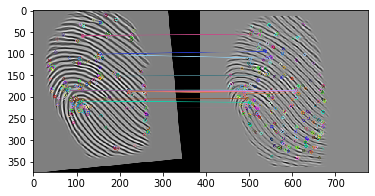

Affine_#inliers:12


<Figure size 432x288 with 0 Axes>

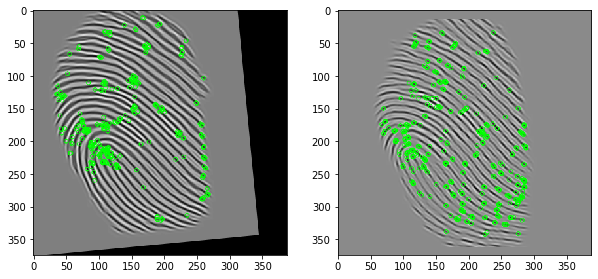

In [13]:
# visualization of the matches after affine transformation
height, width = images_enhanced_db1[testNr2].shape[:2]
im1Reg = cv2.warpAffine(images_enhanced_db1[testNr1], M, (width, height))

# only the inlier matches (matched) are shown
imMatches = cv2.drawMatches(im1Reg, kp1_reg, images_enhanced_db1[testNr2], kp2, matched, None) #, flags=2)
plt.imshow(imMatches), plt.show()

# Note; the hypothesis is that the transformation will be most of the time OK for genuine
# pairs, but wrong for imposter pairs. 

# show all keypoints after geometric matching

print("Affine_#inliers:{}".format(len(matched)))
show_img1 = cv2.drawKeypoints(im1Reg, kp1_reg, None, (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)
show_img2 = cv2.drawKeypoints(images_enhanced_db1[testNr2], kp2, None, (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DEFAULT)

ax = plt.figure()
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))
ax[0].imshow(show_img1)
ax[1].imshow(show_img2)
plt.show()

# FingerPrint Matcher

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pickle
from tqdm import tqdm
from scipy.spatial import distance
import pandas as pd
import os
import sys
project_path=os.path.dirname(os.getcwd()) 
sys.path.append(project_path)
from BioAssigment1.CMC import CMC
from BioAssigment1.Evaluation import Metrics

class fpMatcher(object):
    def __init__(self,dataset_path,keypoint_extractor,detector_opts,distance_metric):
        self.dataset_path = dataset_path
        self.keypoint_extractor = keypoint_extractor
        self.matcher = cv2.BFMatcher(distance_metric, crossCheck=True)
        self.detector = self.keypoint_extractor(**detector_opts)
        self.images = None
        self.labels = None
        self.masks = None
    
    def is_defined(self,argument):
        if(getattr(self,argument)==None):
            raise ValueError
    def sample_pairs(self,genuine=True):
        """Sample pair of random test images from dataset:
            if genuine = True, sample two images from same individual
            otherwise, it present images from different individuals"""
        try:
            is_defined(self,"images")
        except:
            self.get_enhanced_images()
        #Random sample
        idx1=np.random.randint(0,len(self.labels)-1)
        #get label of random instance
        label_1=self.labels[idx1]
        if genuine:
            #get random instance with label==label_1
            idx_list = np.squeeze(np.argwhere(self.labels == label_1)) #genuine indexes
        else:
            #get random instance with label!=label_1
            idx_list = np.squeeze(np.argwhere(self.labels != label_1)) #impostor indexes
        #sample one index from correspondant list(genuine or impostors)
        idx2=int(np.random.choice(idx_list, 1))
        return [idx1,idx2]

    def get_samples_info(self,idx_list):
        images=[self.images[idx] for idx in idx_list]
        masks=[self.masks[idx] for idx in idx_list]
        labels=[self.labels[idx] for idx in idx_list]
        return images,masks,labels
        
    def get_enhanced_images(self):
        p_file = open(self.dataset_path, "rb" )
        [images, labels, masks] = pickle.load(p_file)
        self.images=images
        self.labels=np.array(labels,dtype=np.int32)
        self.masks=masks

    def detect_raw_kp(self,image):
        kp, desc = self.detector.detectAndCompute(image, None)
        return kp, desc

    def _remove_edge_kps(self,mask, kp, desc):
        mask_b = mask.astype(np.uint8)  #convert to an unsigned byte
        # morphological erosion
        mask_b*=255
        mask_e = cv2.erode(mask_b, kernel = np.ones((5,5),np.uint8), iterations = 5)
        # remove keypoints and their descriptors that lie outside this eroded mask
        kpn = [kp[i] for i in range(len(kp)) if mask_e.item(int(kp[i].pt[1]),int(kp[i].pt[0])) == 255]
        descn = np.vstack([desc[i] for i in range(len(kp)) if mask_e.item(int(kp[i].pt[1]),int(kp[i].pt[0])) == 255])
        return kpn, descn

    def detect_kp(self,image,mask):
        kp,desc = self.detect_raw_kp(image) #raw kp and desc
        kp,desc = self._remove_edge_kps(mask,kp,desc) #remove low quality kps
        return kp, desc

    def match_BruteForce_local(self, images, masks):    
        """Brute Force all pair matcher: returns all pairs of best matches
            depending on type of descriptor use the corresponding norm
            crossCheck=True only retains pairs of 
            keypoints that are each other best matching pair"""
        #get descriptors
        kp1,des1 = self.detect_kp(images[0],masks[0])
        kp2,des2 = self.detect_kp(images[1],masks[1])
        keypoints = [kp1,kp2]
        #get matches
        matches = self.matcher.match(des1, des2)
        # sort matches based on feature distance
        matches.sort(key=lambda x: x.distance, reverse=False)
        return matches,keypoints
    
    def transform_keypoints(self,key_points, transformation_matrix):
        # convert keypoint list to Nx1x2 matrix
        mat_points = cv2.KeyPoint.convert(key_points).reshape(-1,1,2)
        # transform points 
        mat_reg_points = cv2.transform(mat_points, transformation_matrix)
        # return transformed keypoint list
        return cv2.KeyPoint.convert(mat_reg_points)   

    def match_BruteForce_global(self,images,masks,good_match_percent = 0.75):
        #Local matching
        matches,keypoints = self.match_BruteForce_local(images,masks)
        # select the best x percent best matches (on local feature vector level) for further global comparison
        GOOD_MATCH_PERCENT = good_match_percent
        numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
        good_matches = matches[:numGoodMatches]
    
        # retain only the keypoints associated to the best matches 
        src_pts = np.float32([keypoints[0][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints[1][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        # estimate an optimal 2D affine transformation with 4 degrees of freedom,
        # limited to combinations of translation, rotation, and uniform scaling
        
        # this is the core of the global consistency check: if we find the correct transformation
        # (which we expect for genuine pairs and not for imposter pairs), we can use it as an
        # additional check by verifying the geometrical quality of the match
        
        # M stores the optimal transformation
        # inliers stores the indices of the subset of points that were finally used to calculate the optimal transformation
        
        M, inliers = cv2.estimateAffinePartial2D(src_pts, dst_pts, method =  cv2.RANSAC, 
                                                confidence = 0.9, ransacReprojThreshold = 10.0, 
                                                maxIters = 5000, refineIters = 10)

        # get the inlier matches
        matched = [x for x,y in zip(good_matches, inliers) if y[0] == 1]

        # The optimal transformation is only correct for genuine pairs in about 75% of cases (experimentally on dataset DB1).
        # One can build additional checks about the validity of the transformation,
        # e.g. too large translations, rotations and/or scale factors
        
        # A simple one is to test the number of keypoints that were used in calculating the transformation. 
        # If this number is is too small, then the transformation is most possibly unreliable. 
        # In that case, we reset the transformation to the identity
        if np.sum(inliers) < 5:
            M = np.eye(2, 3, dtype=np.float32)

        # transform the first keypoint set using the transformation M
        kp1_reg = self.transform_keypoints(keypoints[0], M)
        return kp1_reg, matched, M, keypoints

    def keypoint_plot(self,images,masks,labels=None):
        """Plot keypoint extraction results on test image"""
        ax = plt.figure()
        _, ax = plt.subplots(nrows = 1, ncols = len(images), figsize=(10,10))
        for i,(img,mask) in enumerate(zip(images,masks)):
            #compute keypoints
            kp,_ = self.detect_kp(img,mask)
            #draw keypoints on image
            kp_result_image = cv2.drawKeypoints(img,
                                                 kp, None, (255, 0, 0), 
                                                 cv2.DRAW_MATCHES_FLAGS_DEFAULT)
            # Add to correspondant matplotlib subplot
            ax[i].imshow(kp_result_image)
            if(labels is not None):
                ax[i].set_title(f"label of image : {labels[i]}")
        plt.show()

    def local_matching_plot(self,images, masks):
        #Local matching
        matches,keypoints = self.match_BruteForce_local(images,masks)
        # show the result using drawMatches
        imMatches = cv2.drawMatches(images[0],keypoints[0],
                                    images[1],keypoints[1],matches, None) 
        plt.imshow(imMatches)
        plt.show()
    
    def global_matching_plot(self, images, masks):
        #global matching
        kp1_reg, matched, M, keypoints = self.match_BruteForce_global(images,masks)
        # visualization of the matches after affine transformation
        height, width = images[1].shape[:2]
        im1Reg = cv2.warpAffine(images[0], M, (width, height))

        # only the inlier matches (matched) are shown
        imMatches = cv2.drawMatches(im1Reg, kp1_reg,
                                    images[1], keypoints[1], matched, None) #, flags=2)
        plt.imshow(imMatches)
        plt.show()
        print("Number of affine inliers :{}".format(len(matched)))
    
    def local_scoring(self,images,masks,score_fcn,**kwargs):
        #Local matching
        matches, _ = self.match_BruteForce_local(images,masks)
        #score
        score = score_fcn(matches,**kwargs)
        return score


# Scorer

In [6]:
class pair_sampler(object):
    """Auxiliary Class to get a sample id with same label as query_label
        Used to easily build similarity_scores_tensor
        see : _compute_similarity_tensor()"""
    def __init__(self,labels):
        self.labels=np.array(labels,dtype=np.int32)
    def __call__(self,query_label):
        #find id
        found_id = np.argwhere(self.labels == query_label)[0] #first occurence of label==query_label
        #set label of found_id to -1 so we can´t get this same id again
        self.labels[found_id] = -1
        return int(found_id)
    
class fpScorer(fpMatcher):
    def __init__(self,dataset_path,keypoint_extractor,detector_opts,distance_metric):
        super(fpScorer,self).__init__(dataset_path,keypoint_extractor,detector_opts,distance_metric)

    def is_defined(self,argument):
        if(getattr(self,argument)==None):
            raise ValueError
    def local_score_dataset(self,downsampling=True,**kwargs):
        try:
            is_defined(self,"images")
        except:
            self.get_enhanced_images()
        if(downsampling):
            #get reduced set of total dataset (eg. 30 samples)
            index_list = list(np.random.choice(len(self.images), 30,replace=False))
        else:
            index_list = range(len(self.images))
        genuine_ids=[]
        scores=[]   
        for count,idx1 in tqdm(enumerate(index_list)):
            rest_idx = index_list[count+1:]
            for idx2 in rest_idx:
                #get samples info
                images,masks,labels= self.get_samples_info([idx1,idx2])
                #local matching
                matches,_ = self.match_BruteForce_local(images,masks)
                #score
                score = self.get_local_scoring(matches,**kwargs)
                #update
                scores.append(score)
                label = 1 if labels[0]==labels[1] else 0
                genuine_ids.append(label) 

        scores = np.array(scores,dtype=np.float32)
        genuine_ids = np.array(genuine_ids,dtype=np.int32)
        return scores,genuine_ids

    def global_score_dataset(self,downsampling=True,**kwargs):
        try:
            is_defined(self,"images")
        except:
            self.get_enhanced_images()
        if(downsampling):
            #get reduced set of total dataset (eg. 30 samples)
            index_list = list(np.random.choice(len(self.images), 30,replace=False))
        else:
            index_list = range(len(self.images))
        genuine_ids=[]
        scores=[]   
        for count,idx1 in tqdm(enumerate(index_list)):
            rest_idx = index_list[count+1:]
            for idx2 in rest_idx:
                #get samples info
                images,masks,labels= self.get_samples_info([idx1,idx2])
                #global matching
                _, global_matches, _, keypoints = self.match_BruteForce_global(images,masks)
                #score
                score = self.get_global_scoring(global_matches,keypoints)
                #update
                scores.append(score)
                label = 1 if labels[0]==labels[1] else 0
                genuine_ids.append(label) 

        scores = np.array(scores,dtype=np.float32)
        genuine_ids = np.array(genuine_ids,dtype=np.int32)
        return scores,genuine_ids

    def combine_scores(self,scores,agg_fcn,**kwargs):
        #Aggregate function(agg_fcn) to local & Global scores
        final_scores = agg_fcn(*scores,**kwargs)
        return final_scores

    def _compute_similarity_tensor(self):
        try:
            is_defined(self,"labels")
        except:
            self.get_enhanced_images()
        #init sampler
        sampler = pair_sampler(self.labels)
        #get users idx
        users=set(self.labels)
        enrollees=users
        users_idx=[sampler(user) for user in users]
        
        #init tensor
        fp_per_individual = len(self.labels[self.labels == 1])
        similarity_tensor = np.empty([fp_per_individual - 1,len(users),len(users)])

        for batch_id in tqdm(range(fp_per_individual - 1)):
            for enrollee in enrollees:
                #sample enrrolee id
                enrollee_id = sampler(enrollee)
                for user_id,user in zip(users_idx,users):
                    #get pair info
                    images,masks, _= self.get_samples_info([user_id,enrollee_id])
                    #score
                    _, global_matches, _, keypoints = self.match_BruteForce_global(images,masks)
                    score = self.get_global_scoring(global_matches,keypoints)
                    #fill tensor
                    #users,enrrolees in {1,10} --> index == user -1
                    similarity_tensor[batch_id,user-1,enrollee-1] = score
        return similarity_tensor,users,enrollees

    def construct_similarity_matrix(self,agg_fcn,**kwargs):
        #get similarity tensor
        similarity_tensor,users,enrrollees = self._compute_similarity_tensor()
        # get similarity matrix after aggragation transformation given by agg_fcn
        similarity_matrix = agg_fcn(similarity_tensor,**kwargs)
        # set index and columns (users,enrrolees)
        similarity_matrix = pd.DataFrame(similarity_matrix,index=users,columns=enrrollees)
        return similarity_matrix

    def get_local_scoring(self,matches,N_best):
        #get kp distances from top N best matches
        best_matches_distances=np.array([matches[idx].distance 
                                        for idx in range(N_best)],dtype=np.float32)
        #local score == Inverse of mean feature distances 
        score = 1/ (np.mean(best_matches_distances) + 1)
        return score


    def get_global_scoring(self,global_matches,keypoints):
        #get affine keypoints from matches
        # retain only the keypoints associated to the best matches 
        src_pts = np.float32([keypoints[0][m.queryIdx].pt for m in global_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints[1][m.trainIdx].pt for m in global_matches]).reshape(-1, 1, 2)
        #get distances
        geometric_distances = np.float32([distance.euclidean(kp1,kp2) for kp1,kp2 in zip(src_pts,dst_pts)])
        inv_distances = 1./geometric_distances
        #global score == Inverse of mean geometrical distances 
        # scale_factor = (len(global_matches)/len(keypoints[0])+len(keypoints[1]))
        score = np.sum(inv_distances)
        # score  = len(global_matches)
        return score



## TASKS

Implement the following tasks for one of the 4 databases. I suggest either DB1 or DB2, since they seem a little easier.

#### <font color=blue> Task 1 Test different Keypoint Detectors/Descriptors

* OpenCV provides different KeyPoint detectors and descriptors (ORB, SIFT, SURF, BRIEF, ...). Briefly test, visually, which of these seem to extract relatively reliable interesting points from the fingerprints.
* Note that for some of the KeyPoint descriptors, you need to have a special licence or a full implementation. Skip if you do not have it.
* You also may have to tune the parameters of these detectors.
* But don't spend too much time on this testing step. 
* If you do have the time and the computational resources, you can compare not just visually but by calculating all through using ROC and CMC curves as evidence (Cf. task 3)
</font>

In [7]:
#set up
dataset_path= "./fprdata/DB1_enhanced.p"
detector_opts={} # Default options
detector=cv2.ORB_create
fpmatcher_default=fpMatcher(dataset_path,detector,detector_opts,cv2.NORM_HAMMING)

#Sampling genuine pair of fp
images,masks,labels= fpmatcher_default.get_samples_info(fpmatcher_default.sample_pairs(genuine=True))

# KAZE features

<Figure size 432x288 with 0 Axes>

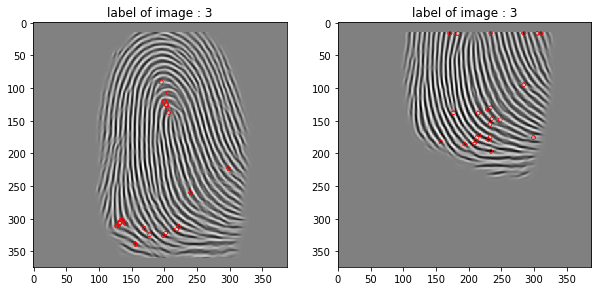

In [5]:
#test sampler (same individual)
detector=cv2.KAZE_create
fpmatcher_kaze=fpMatcher(dataset_path,detector,detector_opts,cv2.NORM_HAMMING)
fpmatcher_kaze.keypoint_plot(images,masks,labels)

# AKAZE

<Figure size 432x288 with 0 Axes>

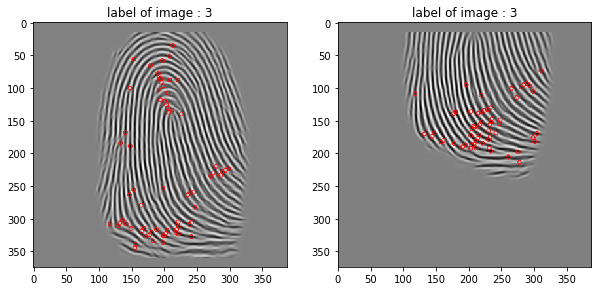

In [30]:
detector=cv2.AKAZE_create
detector_opts={"threshold": 0.0012}
fpmatcher_akaze=fpMatcher(dataset_path,detector,detector_opts,cv2.NORM_HAMMING)
fpmatcher_akaze.keypoint_plot(images,masks,labels)

# BRISK

<Figure size 432x288 with 0 Axes>

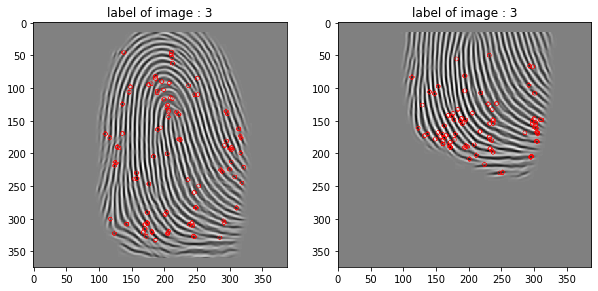

In [22]:
detector=cv2.BRISK_create
detector_opts={"thresh": 45}
fpmatcher_brisk=fpMatcher(dataset_path,detector,detector_opts,cv2.NORM_HAMMING)
fpmatcher_brisk.keypoint_plot(images,masks,labels)

# ORB

<Figure size 432x288 with 0 Axes>

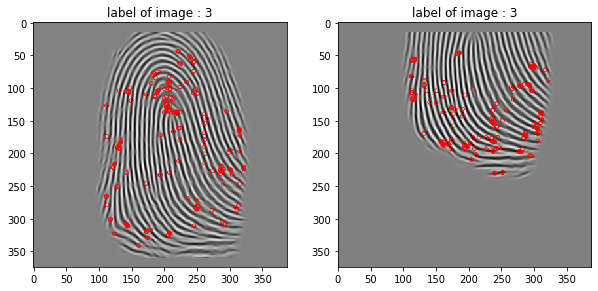

In [23]:
detector=cv2.ORB_create
detector_opts={"nfeatures": 200}
fpmatcher_orb=fpMatcher(dataset_path,detector,detector_opts,cv2.NORM_HAMMING)
fpmatcher_orb.keypoint_plot(images,masks,labels)

#### <font color=blue> Task 2. Determine a matching function
    
You have been given code to calculate matches on a local level and to calculate an affine transformation that allows a more global consistency check. 
    
Define and test different matching functions that make use of these two-level features.
    
1. a function based only on the local features (e.g. number of pairs with feature distance below a set distance threshold, the sum or mean of the feature distance of the best N pairs, or any other function you think is a good candidate)
2. a function based on the geometrical distances between pairs of KeyPoints are affine transformation. For instance, you can take again a brute force matcher that, instead of pairwise feature descriptor distances, computes pairwise geometrical distances between the two point sets. From there on you can then define different measures (number of below a threshold or sum/mean of distances, ...). You can also limit the number of point pairs to apply this to to the matching pairs that result from the local match and/or the ones that are returned as 'matched' by the Ransac procedure. 
3. any combination of local and global match metrics
    
</font>

#### <font color=blue>  Task 3 Test complete system for authentication and identification scenario's

* Choose (at least) one of the databases provided
* calculate the ROC (false match to false non match rate) for an authentication scenario 
* and a Cumulative Match Characteristic (CMC) curve, which plots the rank (order in the candidate list) on the x-axis and the probability of identification at that or better rank on the y-axis. Feel free to reuse your code of the previous assignment!

* Of course you can calulate and store the features upfront before starting the validation procedures.
* Also follow the pipeline and the datastructure of the first assignment on validation, where you calculated genuine and imposter scores (cf. the genuine_id and scores lists that you generated)
    
    
    
</font>

# BRISK

In [8]:
detector=cv2.BRISK_create
detector_opts={}
fpscorer=fpScorer(dataset_path,detector,detector_opts,cv2.NORM_HAMMING)

# Local

In [9]:
scoring_otps={"N_best": 15}
scores,labels = fpscorer.local_score_dataset(downsampling=False,**scoring_otps)
metric_logger_local=Metrics(scores,labels,"Local")


80it [02:39,  2.00s/it]


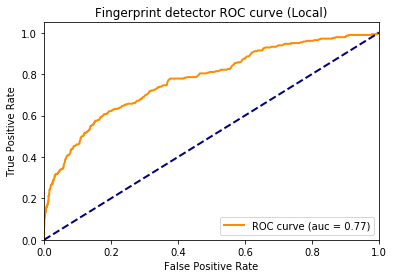

In [10]:
_,ax=plt.subplots(1,1)
metric_logger_local.plot_roc_curve(ax)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1993.59it/s]


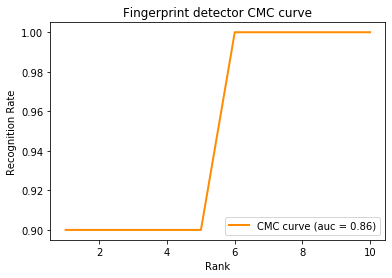

In [13]:
agg_fcn = np.sum
fcn_args ={"axis" : 0}
similarity_matrix=fpscorer.construct_similarity_matrix(agg_fcn,**fcn_args)
#cmc
cmc_obj=CMC(similarity_matrix)
_,ax=plt.subplots(1,1)
cmc_obj.plot_CMC_curve(ax)
plt.show()  

# Global

In [11]:
scores,labels = fpscorer.global_score_dataset(downsampling=False)
metric_logger_global=Metrics(scores,labels,"Global")

80it [02:47,  2.10s/it]


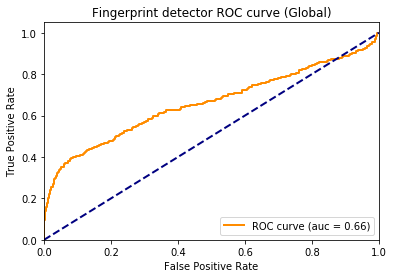

In [12]:
_,ax=plt.subplots(1,1)
metric_logger_global.plot_roc_curve(ax)
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2491.42it/s]


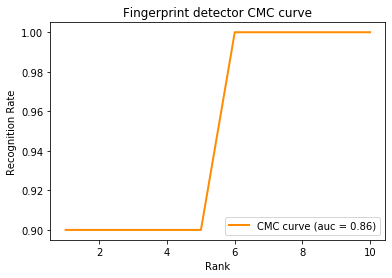

In [14]:
agg_fcn = np.sum
fcn_args ={"axis" : 0}
similarity_matrix=fpscorer.construct_similarity_matrix(agg_fcn,**fcn_args)
#cmc
cmc_obj=CMC(similarity_matrix)
_,ax=plt.subplots(1,1)
cmc_obj.plot_CMC_curve(ax)
plt.show()  

#### <font color=blue>  Task 4 Discuss your results
    
* which parts are critical?
* given more time, how would you improve?
* compare your results to the results that are available [online](http://bias.csr.unibo.it/fvc2002/results.asp) 